# 1. Life Modeling

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset Load

In [24]:
df = pd.read_csv('new_dataset.csv')

## Preprocessing

In [25]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.rename(columns={"alchol":"alcohol"})

In [26]:
df['alcohol'] = df['alcohol'].apply(lambda x: 1 if x >= 1 else 0)
df['smoke'] = df['smoke'].apply(lambda x: 1 if x >= 1 else 0)
df['gym'] = df['gym'].apply(lambda x: 1 if x > 1 else 0)

df['stress'] = df['stress'].apply(lambda x: 1 if x >= 3 else 0)
df['walk'] = df['walk'].apply(lambda x: 1 if x >= 5 else 0)

## Columns 구분

In [27]:
# 생활습관에 관련된 columns
# 성별, 나이, 음주빈도, 평소 스트레스인지 정도, 하루평균 일반담배(궐련) 흡연량,
# 1주일간 걷기 일수, 1주일간 근력운동일수, 허리둘레, 중성지방, HDL 고밀도 지방
# 최종 수축기 혈압, 최종 이완기 혈압, 공복혈당, 주중 수면 시간, 주말 수면 시간
life_col = ['sex', 'age', 'alcohol', 'stress', 'smoke', 'walk', 'gym', 'time_w', 'time_wk']

In [28]:
# 대서성 증후군의 판단 기준이 되는 columns: 허리둘레, 중성지방, 고밀도 지방, 최종 수축기 혈압, 최종 이완기 혈압, 공복혈당
# 수축기 혈압 130mmHg 이상 또는 이완기 혈압 85mmHg 이상인 경우이므로 수축기 혈압과 이완기 혈압 모두 columns에 포함
meta_col = ['waist', 'colesterol_m', 'colesterol_h', 'contraction', 'relaxation', 'bloodsugar', 'metabolic']

In [29]:
# 영양소에 관련된 columns
# 에너지, 물, 단백질 등등
nutri_col = ['energy', 'water', 'protein', 'fat', 'sa_fat',
       'mono_unsa_fat', 'poly_unsa_fat', 'n3_fat', 'n6_fat',
       'colesterol_total', 'carbohydrate', 'dietary_fiber', 'sugar', 'calcium',
       'phosphorus', 'natrium', 'kalium', 'magnesium', 'iron', 'zinc',
       'vitamin_a', 'vitamin_D', 'vitamin_e', 'carotene',
       'bitamin_b1', 'bitamin_b2', 'vitamin_b3', 'vitamin_b9', 'vitamin_c']

## Training Set and Test Set
- Column을 나눔: 생활습관 관련, 대사성 증후군 관련, 영양소 관련
- 대사성 증후군의 판단 기준이 되는 columns을 사용하여 대사성 증후군을 예측했기 때문에 meta_col은 모델링에 필요 없는 columns
- X, y로 나누고 train set과 test set으로 분리
- 필요하다면 test set을 test set과 valid set으로 분리 가능

In [30]:
X = df[life_col]
y = df['metabolic'] # target

In [31]:
# train_test_split에서 stratify는 분류(classification)를 다룰 때 매우 중요한 옵션값, stratify 값을 target으로 지정하면 각각의 class 비율(ratio)을 train / validation에 유지(한 쪽에 쏠려서 분배되는 것을 방지
# 만약 이 옵션을 지정하지 않고 분류(classification) 문제를 다루면, 성능의 차이가 많이 날 가능성 높음
# 현재 Dataset에서 대사성 증후군인 사람과 아닌 사람의 비율 = 1:4
# 이 비율 그대로 train, test 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

## Feature Scaling
- 수업 시간에 배운 표준화(Standardization)과 정규화(Normalization)을 적용 가능
- Decision Tree는 규칙에 대해 학습하는 것이므로 성능의 차이 없음

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [33]:
# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# 정규화
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## 1st Model - Decision Tree

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [36]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
import multiprocessing

### SMOTE 적용

In [37]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

In [38]:
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (6305, 9) (6305,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (10248, 9) (10248,)
SMOTE 적용 후 값의 분포 :
 1    5124
0    5124
Name: metabolic, dtype: int64


### Parameter 수정
DecisionTreeClassifier()의 parameters
1. criterion: “gini”, “entropy”, “log_loss”
 - default: ”gini”
2. splitter: “best”, “random”
 - defalut: ”best”
3. max_depth: integer
 - 트리의 최대 깊이
 - defalut: None → 완벽하게 클래스 값이 결정될 때 까지 분할
 - 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요
4. min_samples_split: integer or float
 - 노드를 분할하기 위한 최소한의 샘플 데이터수
 - default: 2 → 작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가
5. min_samples_leaf: integer or float
 - 리프노드가 되기 위해 필요한 최소한의 샘플 데이터수
 - 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요
 - default: 2
6. max_features: “auto”, “sqrt”, “log2”
 - 최적의 분할을 위해 고려할 최대 feature 개수
 - default: None → 데이터 세트의 모든 피처를 사용
 - int형으로 지정 →피처 갯수 / float형으로 지정 →비중
 - sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 선정
 - log2 : 전체 피처 중 log2(전체 피처 개수) 만큼 선정
7. max_leaf_nodes: integer
 - 리프노드의 최대 개수
 - defalut: None
8. min_impurity_decrease: float
 - default: 0.0
9. min_weight_fraction_leaf: float,
 - default: 0.0

3, 4, 5, 6, 7번 Parameter가 중요하므로 이 위주로 수정

출처: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [39]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [40]:
dt = DecisionTreeClassifier()

param_grid = [{'criterion':["gini","entropy"],'max_depth':[6,8,10,12],'min_samples_split':[6,8,10,12,14], 'min_samples_leaf':[2,3,4,5,6,7,8],
               'max_features':["auto", "sqrt", "log2"]}]

gs = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=multiprocessing.cpu_count())
gs

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [6, 8, 10, 12],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8],
                          'min_samples_split': [6, 8, 10, 12, 14]}],
             scoring='recall')

In [41]:
result = gs.fit(X_train_over, y_train_over)
print(gs.best_estimator_) # 이 모델 사용
print('최고 평균 재현율(Recall): {}'.format(gs.best_score_))
print('최적 파라미터: {}'.format(gs.best_params_))
pd.DataFrame(result.cv_results_)

DecisionTreeClassifier(max_depth=12, max_features='auto', min_samples_leaf=2,
                       min_samples_split=12)
최고 평균 재현율(Recall): 0.7513791920731707
최적 파라미터: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 12}


C:\Users\82104\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021542,0.006692,0.009773,0.005179,gini,6,auto,2,6,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.513171,0.818537,0.548293,0.684878,0.666992,0.646374,0.108546,684
1,0.019349,0.010221,0.006582,0.001017,gini,6,auto,2,8,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.668293,0.646829,0.648780,0.637073,0.610352,0.642265,0.018901,707
2,0.027726,0.018232,0.013166,0.011023,gini,6,auto,2,10,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.618537,0.673171,0.649756,0.714146,0.618164,0.654755,0.036172,621
3,0.019748,0.008113,0.007579,0.002863,gini,6,auto,2,12,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.602927,0.620488,0.674146,0.702439,0.746094,0.669219,0.052549,496
4,0.020346,0.006232,0.006183,0.000399,gini,6,auto,2,14,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.585366,0.677073,0.674146,0.678049,0.624023,0.647732,0.037227,675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.026130,0.003241,0.010372,0.003710,entropy,12,log2,8,6,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.587317,0.729756,0.764878,0.764878,0.739258,0.717217,0.066423,32
836,0.033509,0.011119,0.022140,0.026233,entropy,12,log2,8,8,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.466341,0.683902,0.800976,0.753171,0.763672,0.693612,0.119774,251
837,0.022938,0.004370,0.006982,0.001784,entropy,12,log2,8,10,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.588293,0.744390,0.732683,0.732683,0.785156,0.716641,0.067011,35
838,0.029322,0.002721,0.007579,0.000798,entropy,12,log2,8,12,"{'criterion': 'entropy', 'max_depth': 12, 'max...",0.504390,0.691707,0.797073,0.766829,0.757812,0.703562,0.105357,140


학습 데이터 점수:  71.14
평가 데이터 점수:  66.52


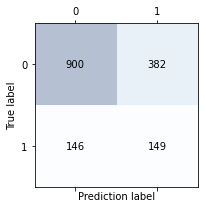

정확도(accuracy):  0.67
정밀도(precision):  0.28
재현율(recall):  0.51
F1 score:  0.36


In [42]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=10, max_features="log2", min_samples_leaf=3, min_samples_split=12, random_state=4)
dt.fit(X_train_over, y_train_over)
predict = dt.predict(X_test)

train_score = dt.score(X_train_over, y_train_over)
test_score = dt.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

## 2nd Model - SVC
- SVM은 입력 데이터가 정규화 되어야 좋은 성능을 보임
- 주로 모든 특성 값을 [0, 1] 사이의 범위로 만듦
- Standardization 또는 MinMaxScaler 사용

In [43]:
from sklearn.svm import SVC

### Parameter 수정
SVC()의 Parameter
1. gamma (default='scale'): 'rbf', 'sigmoid', 'poly'에 대한 커널 계수결정 
 - 경계를 얼마나 유연하게 그을 것인지 정함
 - 학습 데이터에 얼마나 민감하게 반응할 것인지 모델을 조정(C와 비슷한 개념) 
 - gamma 값을 높이면 학습 데이터에 많이 의존해서 구불구불한 경계 그음(오버피팅을 초래 가능)
 - gamma 값을 낮추면 학습 데이터에 별로 의존하지 않고 결정 경계를 직선에 가깝게 그음(언더피팅이 발생 가능)
 - 'auto', 'scale' 존재
2. C (default=1.0): 규제의 강도를 조절
 - C값이 클수록 하드마진(오류 허용 안 함) -> Hard
 - 작을수록 소프트마진(오류를 허용함) -> Soft
3. kernel (default='rbf'): 알고리즘에 사용할 커널 유형 지정
 - 원래 가지고 있는 데이터를 더 높은 차원의 데이터로 변환
 - 'linear', 'poly', 'sigmoid', 'rbf', 'precomputed' 존재
 - 'poly'는 3차원, 'rbf'는 무한한 차원

In [44]:
param_grid = [{'gamma': ['auto', 'scale'], 
               'C': [0.01, 0.1, 1.0, 10, 100], 'kernel':['linear','poly','sigmoid']}]

gs = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='recall',
    n_jobs=multiprocessing.cpu_count(),
    verbose=True)
gs

GridSearchCV(estimator=SVC(), n_jobs=8,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10, 100],
                          'gamma': ['auto', 'scale'],
                          'kernel': ['linear', 'poly', 'sigmoid']}],
             scoring='recall', verbose=True)

In [45]:
result = gs.fit(X_train_over, y_train_over)
print(gs.best_estimator_)
print("최적 점수: {}".format(gs.best_score_))
print("최적 파라미터: {}".format(gs.best_params_))
pd.DataFrame(result.cv_results_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVC(C=10, gamma='auto', kernel='poly')
최적 점수: 0.6699879954268293
최적 파라미터: {'C': 10, 'gamma': 'auto', 'kernel': 'poly'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.763958,0.309263,1.354577,0.158273,0.01,auto,linear,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}",0.595122,0.605854,0.631220,0.615610,0.614258,0.612413,0.011911,15
1,9.949985,0.608404,1.627447,0.220501,0.01,auto,poly,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}",0.499512,0.505366,0.489756,0.496585,0.508789,0.500002,0.006676,29
2,10.614809,1.072761,1.940409,0.078446,0.01,auto,sigmoid,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}",0.592195,0.594146,0.614634,0.610732,0.587891,0.599920,0.010688,20
3,7.955922,0.541726,1.363751,0.128615,0.01,scale,linear,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",0.595122,0.605854,0.631220,0.615610,0.614258,0.612413,0.011911,15
4,9.184234,0.507102,1.510960,0.031304,0.01,scale,poly,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}",0.501463,0.505366,0.485854,0.494634,0.503906,0.498245,0.007207,30
5,11.464335,0.228046,1.848855,0.046074,0.01,scale,sigmoid,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmo...",0.592195,0.594146,0.615610,0.610732,0.589844,0.600505,0.010544,19
6,11.545119,3.320577,2.172788,1.414979,0.1,auto,linear,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.596098,0.614634,0.628293,0.608780,0.614258,0.612413,0.010391,15
7,16.900196,0.470896,1.573989,0.147279,0.1,auto,poly,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",0.636098,0.638049,0.658537,0.639024,0.667969,0.647935,0.012892,8
8,12.868938,1.084357,1.689326,0.265703,0.1,auto,sigmoid,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}",0.560000,0.567805,0.582439,0.564878,0.563477,0.567720,0.007776,22
9,9.002117,0.470587,1.297690,0.188767,0.1,scale,linear,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.596098,0.614634,0.628293,0.608780,0.614258,0.612413,0.010391,15


학습 데이터 점수:  67.98
평가 데이터 점수:  64.11


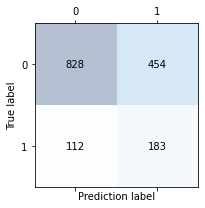

정확도(accuracy):  0.64
정밀도(precision):  0.29
재현율(recall):  0.62
F1 score:  0.39


In [46]:
svc = SVC(gamma= "auto", C=10, kernel="poly")
svc.fit(X_train_over, y_train_over)
predict = svc.predict(X_test)

train_score = svc.score(X_train_over, y_train_over)
test_score = svc.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

## 3rd Model - Association Rule Discovery

### Preprocessing

In [47]:
itemset = ['metabolic','alcohol', 'stress', 'smoke', 'walk', 'gym']

In [48]:
# Transaction Dataset
td = df[itemset]

In [49]:
td.drop(td[(td['metabolic'] == 0)].index, inplace=True)
td.reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,metabolic,alcohol,stress,smoke,walk,gym
0,1,1,0,0,1,0
1,1,1,0,0,1,0
2,1,1,1,0,1,0
3,1,1,0,0,1,0
4,1,1,1,0,1,1
...,...,...,...,...,...,...
1471,1,0,1,0,1,1
1472,1,1,0,0,0,0
1473,1,1,1,0,0,0
1474,1,1,0,0,1,0


In [50]:
td.describe()

,metabolic,alcohol,stress,smoke,walk,gym
count,1476.0,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000
mean,1.0,0.960705,0.623306,0.288618,0.497967,0.224255
std,0.0,0.194363,0.484721,0.453273,0.500165,0.417232
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
td['alcohol'] = td['alcohol'].apply(lambda x: 1 if x >= 1 else 0)
td['smoke'] = td['smoke'].apply(lambda x: 1 if x >= 1 else 0)
td['gym'] = td['gym'].apply(lambda x: 1 if x > 1 else 0)

td['stress'] = td['stress'].apply(lambda x: 1 if x >= 3 else 0)
td['walk'] = td['walk'].apply(lambda x: 1 if x >= 5 else 0)

<ipython-input-51-f61e5d27fb7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td['alcohol'] = td['alcohol'].apply(lambda x: 1 if x >= 1 else 0)
<ipython-input-51-f61e5d27fb7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td['smoke'] = td['smoke'].apply(lambda x: 1 if x >= 1 else 0)
<ipython-input-51-f61e5d27fb7f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

### Convert Dataset to Transaction Dataset

In [52]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [53]:
te = TransactionEncoder()
te_result = te.fit(td).transform(td)

# Create the Apriori model
model = apriori(td, min_support=0.1, use_colnames=True)

# Create the association rules
rules = association_rules(model, metric="lift", min_threshold=0.5).sort_values(by = ['lift'], ascending =False)
rules

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
5,(alcohol),(smoke),0.960705,0.288618,0.285908,0.297602,1.031129,0.008631,1.012791,0.768263
8,"(metabolic, alcohol)",(smoke),0.960705,0.288618,0.285908,0.297602,1.031129,0.008631,1.012791,0.768263
11,(alcohol),"(smoke, metabolic)",0.960705,0.288618,0.285908,0.297602,1.031129,0.008631,1.012791,0.768263
4,(smoke),(alcohol),0.288618,0.960705,0.285908,0.990610,1.031129,0.008631,4.184959,0.042437
6,"(smoke, metabolic)",(alcohol),0.288618,0.960705,0.285908,0.990610,1.031129,0.008631,4.184959,0.042437
9,(smoke),"(metabolic, alcohol)",0.288618,0.960705,0.285908,0.990610,1.031129,0.008631,4.184959,0.042437
0,(metabolic),(alcohol),1.000000,0.960705,0.960705,0.960705,1.000000,0.000000,1.000000,0.000000
1,(alcohol),(metabolic),0.960705,1.000000,0.960705,1.000000,1.000000,0.000000,inf,0.000000
2,(smoke),(metabolic),0.288618,1.000000,0.288618,1.000000,1.000000,0.000000,inf,0.000000
3,(metabolic),(smoke),1.000000,0.288618,0.288618,0.288618,1.000000,0.000000,1.000000,0.000000


# 2. Nutrients Modeling By Discretization

## Dataset Load

In [54]:
df = pd.read_csv('new_dataset.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing

In [55]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.rename(columns={"alchol":"alcohol"})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##  Wrapper Approach

In [56]:
'''
cor_feature = ['phosphorus', 'carotene' , 'sa_fat', 'mono_unsa_fat', 'n6_fat','kalium','vitamin_b3']
cor_size = len(cor_feature)
cor_pow = []
for i in range(2**cor_size):
    flag = bin(i)[2:].zfill(cor_size)
    subset = [cor_feature[j] for j in range(cor_size) if flag[j] == '1']
    cor_pow.append(subset)
    '''

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\ncor_feature = ['phosphorus', 'carotene' , 'sa_fat', 'mono_unsa_fat', 'n6_fat','kalium','vitamin_b3']\ncor_size = len(cor_feature)\ncor_pow = []\nfor i in range(2**cor_size):\n    flag = bin(i)[2:].zfill(cor_size)\n    subset = [cor_feature[j] for j in range(cor_size) if flag[j] == '1']\n    cor_pow.append(subset)\n    "

In [57]:
'''
max_string = ''
max_num = 0;
for i in cor_pow:
    new_x_train = X_train.drop(columns=i)
    new_x_test = X_test.drop(columns=i)
    log_reg = LogisticRegression(C=1,penalty='l2', class_weight=class_weight)
    log_reg.fit(new_x_train,y_train)
    log_acc=accuracy_score(y_test,log_reg.predict(new_x_test))
    predict = log_reg.predict(new_x_test)
    score = accuracy_score(y_test,log_reg.predict(new_x_test))*100
    if(max_num <= score):
        max_string = i
        max_num = score
print(max_string, max_num)
'''

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\nmax_string = ''\nmax_num = 0;\nfor i in cor_pow:\n    new_x_train = X_train.drop(columns=i)\n    new_x_test = X_test.drop(columns=i)\n    log_reg = LogisticRegression(C=1,penalty='l2', class_weight=class_weight)\n    log_reg.fit(new_x_train,y_train)\n    log_acc=accuracy_score(y_test,log_reg.predict(new_x_test))\n    predict = log_reg.predict(new_x_test)\n    score = accuracy_score(y_test,log_reg.predict(new_x_test))*100\n    if(max_num <= score):\n        max_string = i\n        max_num = score\nprint(max_string, max_num)\n"

## 남성과 여성의 영양소 기준치

In [58]:
male_nutri = [2550,1200,65,30, 7,17.0,12.8,1.5,12.25, 
        300,130, 30,50, 800,700, 1500,3500, 365, 10,10, 565, 10,12, 2225,1.2,1.5, 16.0,400.0, 100]

female_nutri = [1950,1000,52.5,30,7,14.1,11.0,1.2,9.25,300,130,20,50,700,700,1500,3500,280,14,8,
          455,10,12,1773,1.1,1,14.0,400.0,100]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 남성과 여성에 대한 Dataset 구분

In [59]:
male_df = df[df['sex'] == 1]
female_df = df[df['sex']== 2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
for i in range(len(nutri_col)):
    column = nutri_col[i]
    standard = male_nutri[i]
    bins = [0]
    bins.append(standard*0.375)
    bins.append(standard*0.75)
    bins.append(standard*1.25)
    bins.append(standard*2)
    bins.append(standard*3)
    max_num = male_df[column].max()
    bins.append(max_num *10)
    male_df[column] = np.digitize(male_df[column], bins)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-60-82aeea5c411a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df[column] = np.digitize(male_df[column], bins)


In [61]:
for i in range(len(nutri_col)):
    column = nutri_col[i]
    standard = female_nutri[i]
    bins = [0]
    bins.append(standard*0.375)
    bins.append(standard*0.75)
    bins.append(standard*1.25)
    bins.append(standard*2)
    bins.append(standard*3)
    max_num = female_df[column].max()
    bins.append(max_num *10)
    female_df[column] = np.digitize(female_df[column], bins)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-61-e696fc9df215>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_df[column] = np.digitize(female_df[column], bins)


In [62]:
X1 = male_df.drop(columns=meta_col)
y1 = male_df['metabolic'] # target

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
X2 = female_df.drop(columns=meta_col)
y2 = female_df['metabolic'] # target

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
X = pd.concat([X1,X2])
y = pd.concat([y1,y2])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
X = X.drop(columns = life_col)
X = X.drop(columns = ['phosphorus', 'carotene', 'mono_unsa_fat', 'n6_fat', 'kalium'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training Set and Test Set

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Class Weight

In [67]:
class_weight = {1: 0.8128,
                0: 0.1872}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1st Model - Decison Tree

학습 데이터 점수:  64.54
평가 데이터 점수:  59.80


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\82104\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


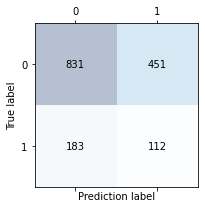

정확도(accuracy):  0.60
정밀도(precision):  0.20
재현율(recall):  0.38
F1 score:  0.26


In [68]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=6,  max_features="auto", min_samples_leaf=2, min_samples_split=6, class_weight=class_weight, random_state=3)
dt.fit(X_train, y_train)
predict = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

## 2nd Model - Regression

In [69]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1,penalty='l2',class_weight=class_weight)
log_reg.fit(X_train,y_train)

log_acc=accuracy_score(y_test,log_reg.predict(X_test))
predict = log_reg.predict(X_test)

print("Train Set Accuracy:"+str(accuracy_score(y_train,log_reg.predict(X_train))*100))
print("Test Set Accuracy:"+str(accuracy_score(y_test,log_reg.predict(X_test))*100))

Train Set Accuracy:57.73195876288659
Test Set Accuracy:56.055802155992396


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\82104\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


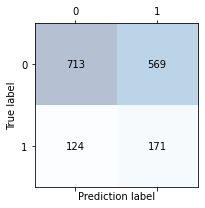

정확도(accuracy):  0.56
정밀도(precision):  0.23
재현율(recall):  0.58
F1 score:  0.33


In [70]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

## 3rd Model - SVC

In [71]:
svc = SVC(kernel='linear',class_weight=class_weight)
svc.fit(X_train, y_train)
predict = svc.predict(X_test)

train_score = svc.score(X_train, y_train)
test_score = svc.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


학습 데이터 점수:  58.41
평가 데이터 점수:  58.08


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


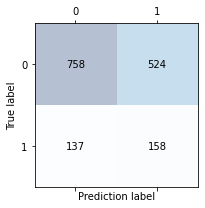

정확도(accuracy):  0.58
정밀도(precision):  0.23
재현율(recall):  0.54
F1 score:  0.32


In [72]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

# 3. Nutrients Modeling By Standardization

## Dataset Load

In [73]:
df = pd.read_csv('new_dataset.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing

In [74]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.rename(columns={"alchol":"alcohol"})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
df['smoke'] = df['smoke'].apply(lambda x: 2 if x >= 10 else (1 if x >= 1 else 0))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##  Wrapper Approach

In [76]:
'''
cor_feature = ['phosphorus', 'carotene' , 'sa_fat', 'mono_unsa_fat', 'n6_fat','kalium','vitamin_b3']
cor_size = len(cor_feature)
cor_pow = []
for i in range(2**cor_size):
    flag = bin(i)[2:].zfill(cor_size)
    subset = [cor_feature[j] for j in range(cor_size) if flag[j] == '1']
    cor_pow.append(subset)
    '''

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\ncor_feature = ['phosphorus', 'carotene' , 'sa_fat', 'mono_unsa_fat', 'n6_fat','kalium','vitamin_b3']\ncor_size = len(cor_feature)\ncor_pow = []\nfor i in range(2**cor_size):\n    flag = bin(i)[2:].zfill(cor_size)\n    subset = [cor_feature[j] for j in range(cor_size) if flag[j] == '1']\n    cor_pow.append(subset)\n    "

In [77]:
'''
max_string = ''
max_num = 0;
for i in cor_pow:
    new_x_train = X_train.drop(columns=i)
    new_x_test = X_test.drop(columns=i)
    log_reg = LogisticRegression(C=1,penalty='l2', class_weight=class_weight)
    log_reg.fit(new_x_train,y_train)
    log_acc=accuracy_score(y_test,log_reg.predict(new_x_test))
    predict = log_reg.predict(new_x_test)
    score = accuracy_score(y_test,log_reg.predict(new_x_test))*100
    if(max_num <= score):
        max_string = i
        max_num = score
print(max_string, max_num)
'''

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\nmax_string = ''\nmax_num = 0;\nfor i in cor_pow:\n    new_x_train = X_train.drop(columns=i)\n    new_x_test = X_test.drop(columns=i)\n    log_reg = LogisticRegression(C=1,penalty='l2', class_weight=class_weight)\n    log_reg.fit(new_x_train,y_train)\n    log_acc=accuracy_score(y_test,log_reg.predict(new_x_test))\n    predict = log_reg.predict(new_x_test)\n    score = accuracy_score(y_test,log_reg.predict(new_x_test))*100\n    if(max_num <= score):\n        max_string = i\n        max_num = score\nprint(max_string, max_num)\n"

## 이상치 제거

In [78]:
def remove_outlier(dataframe, columns):
    df = dataframe
    for col in columns:
        q1 = df[col].quantile(0.25) # 1분위수 (25%)
        q3 = df[col].quantile(0.75) # 3분위수 (75%)
        IQR = q3 - q1
        z = 3 # 1.5? 3?
        df = df[(df[col] <= q3 + z * IQR) & (df[col] >= q1 - z * IQR)]
        df = df.reset_index(drop=True)
    return df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
df = remove_outlier(df, nutri_col)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
X = df.drop(columns=meta_col)
X = X.drop(columns=life_col)
y = df['metabolic'] # target

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Feature Scaling



In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
# 표준화
scaler = StandardScaler()
std_scale = StandardScaler().fit(X[nutri_col])
std = std_scale.transform(X[nutri_col])
std = pd.DataFrame(std, columns=nutri_col, index=list(df.index.values))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Training Set and Test set

In [83]:
X = X.drop(columns = nutri_col)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
X = pd.concat([X,std], axis= 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
X = X.drop(columns = ['carotene', 'n6_fat']) # 상관관계가 높은 column은 모두 제외

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Class Weight

In [87]:
class_weight = {1: 0.8128,
                0: 0.1872}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1st Model - Decison Tree

학습 데이터 점수:  63.82
평가 데이터 점수:  58.68


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\82104\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


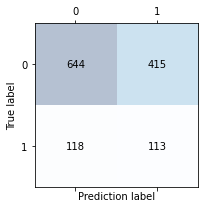

정확도(accuracy):  0.59
정밀도(precision):  0.21
재현율(recall):  0.49
F1 score:  0.30


In [88]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=6,  max_features="auto", min_samples_leaf=2, min_samples_split=6, class_weight=class_weight)
dt.fit(X_train, y_train)
predict = dt.predict(X_test)

train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

## 2nd Model - Regression

In [89]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1,penalty='l2',class_weight=class_weight)
log_reg.fit(X_train,y_train)

log_acc=accuracy_score(y_test,log_reg.predict(X_test))
predict = log_reg.predict(X_test)

print("Train Set Accuracy:"+str(accuracy_score(y_train,log_reg.predict(X_train))*100))
print("Test Set Accuracy:"+str(accuracy_score(y_test,log_reg.predict(X_test))*100))

Train Set Accuracy:60.98837209302326
Test Set Accuracy:59.30232558139535


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\82104\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


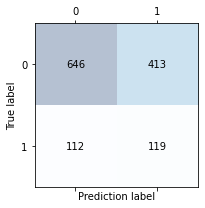

정확도(accuracy):  0.59
정밀도(precision):  0.22
재현율(recall):  0.52
F1 score:  0.31


In [90]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))

## 3rd Model - SVC

In [91]:
svc = SVC(kernel='linear',class_weight=class_weight)
svc.fit(X_train, y_train)
predict = svc.predict(X_test)

train_score = svc.score(X_train, y_train)
test_score = svc.score(X_test, y_test)
print("학습 데이터 점수: {: .2f}".format(train_score * 100))
print("평가 데이터 점수: {: .2f}".format(test_score * 100))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


학습 데이터 점수:  62.31
평가 데이터 점수:  60.39


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


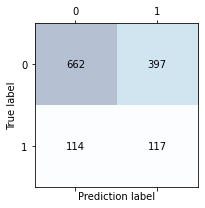

정확도(accuracy):  0.60
정밀도(precision):  0.23
재현율(recall):  0.51
F1 score:  0.31


In [92]:
# Confusion Matrix
confmat = confusion_matrix(y_true=y_test, y_pred=predict)

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)
print("정확도(accuracy): {: .2f}".format(accuracy))
print("정밀도(precision): {: .2f}".format(precision))
print("재현율(recall): {: .2f}".format(recall))

f1 = f1_score(y_test, predict)
print("F1 score: {: .2f}".format(f1))